In [45]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from modules.load_data import load_data

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

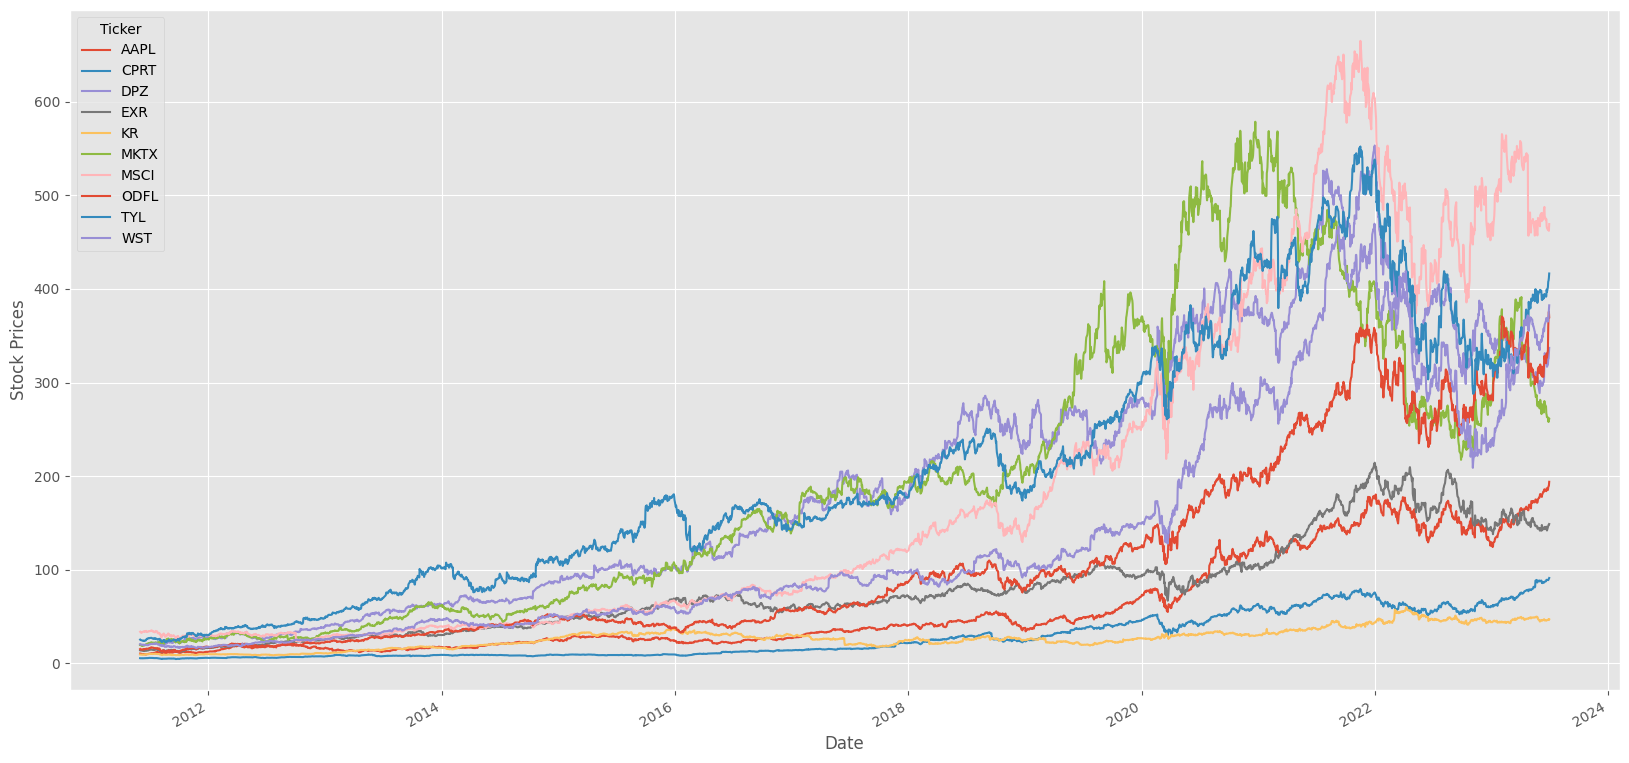

Ticker,AAPL,CPRT,DPZ,EXR,KR,MKTX,MSCI,ODFL,TYL,WST
Date,,,,,,,,,,
2011-06-02,10.50,5.55,19.98,13.94,9.54,19.71,33.84,15.34,25.41,20.53
2011-06-03,10.42,5.49,20.02,13.82,9.47,19.57,33.19,14.95,25.02,20.19
2011-06-06,10.26,5.46,19.49,13.72,9.30,19.32,32.85,14.78,24.78,20.14
2011-06-07,10.08,5.51,19.70,13.90,9.36,19.14,33.30,14.85,24.70,19.97
2011-06-08,10.08,5.49,19.26,13.89,9.49,18.63,33.05,14.75,24.46,20.01
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,185.27,89.10,319.24,145.71,46.65,262.76,463.25,334.54,402.05,365.07
2023-06-27,188.06,88.98,324.93,147.13,46.77,259.37,465.08,359.27,407.74,369.34
2023-06-28,189.25,89.71,325.52,148.00,47.17,257.89,463.32,370.29,408.89,369.21


In [166]:
# Load the data
data = load_data()['prices'].fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

# Keeping just the selected stocks
sel_stocks = ['DPZ', 'WST', 'ODFL', 'MKTX', 'TYL', 'AAPL', 'CPRT', 'MSCI', 'EXR', 'KR']

for stock in data.keys():
  if stock not in sel_stocks:
    data = data.drop(stock, axis=1)

# Plot the data
data.plot()
plt.ylabel('Stock Prices')
plt.xlabel('Date')
plt.show()

data

In [167]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [168]:
sel_data = data['2017-12-29':'2019-06-28']

train_data = sel_data.sample(frac=0.8)
test_data = sel_data[train_data.index[-1]+pd.Timedelta(days=1):]
print('Test interval: ', test_data.index[0], test_data.index[-1])
test_interval_dates = test_data.index

train_data = train_data['DPZ']
test_data = test_data['DPZ']

Test interval:  2018-08-15 00:00:00 2019-06-28 00:00:00


In [169]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [170]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 2336.2473440618523 for model SARIMAX(3, 0, 1)x(3, 1, 1, 12)


In [171]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

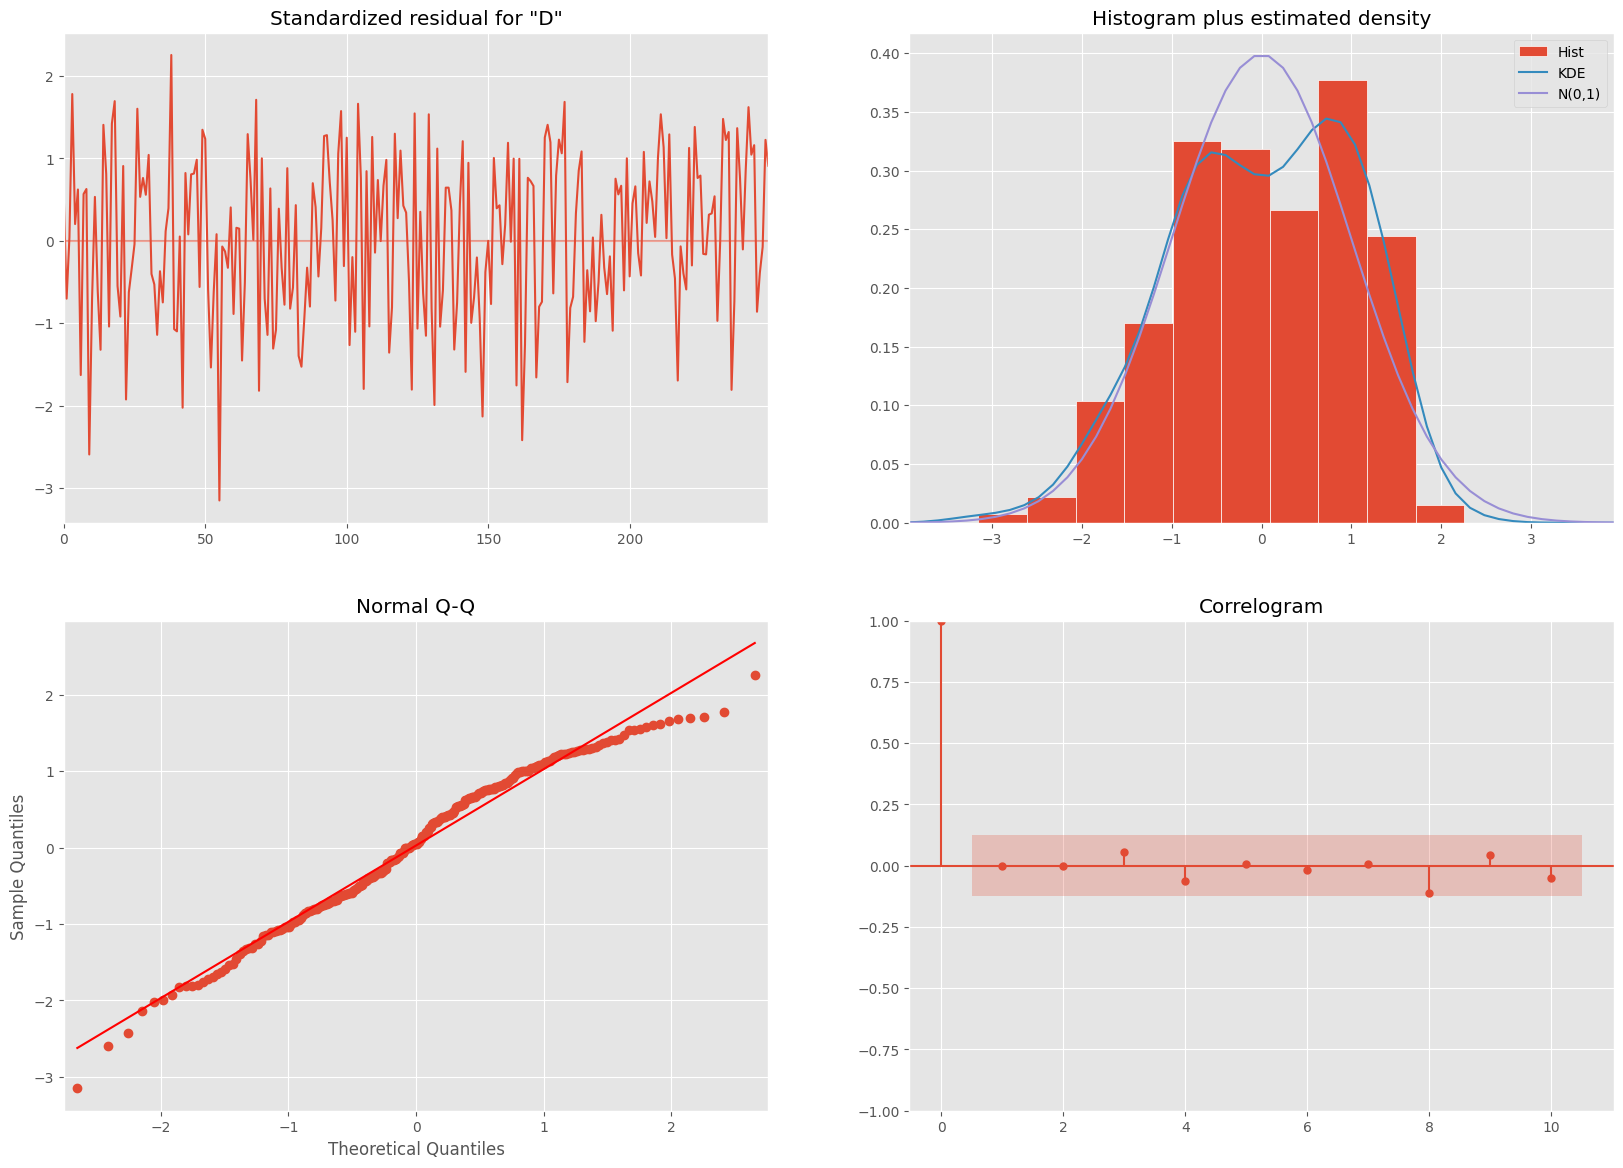

In [172]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [208]:
pred0 = results.get_prediction(start=test_interval_dates[1], dynamic=False)
pred0_mean = pred0.predicted_mean

# for value in pred0_mean.index:
#   if value not in test_interval_dates:
#     pred0_mean = pred0_mean.drop(value)

pred1 = results.get_prediction(start=test_interval_dates[1], dynamic=True)
pred1_mean = pred1.predicted_mean

# for value in pred1_mean.index:
#   if value not in test_interval_dates:
#     pred1_mean = pred1_mean.drop(value)

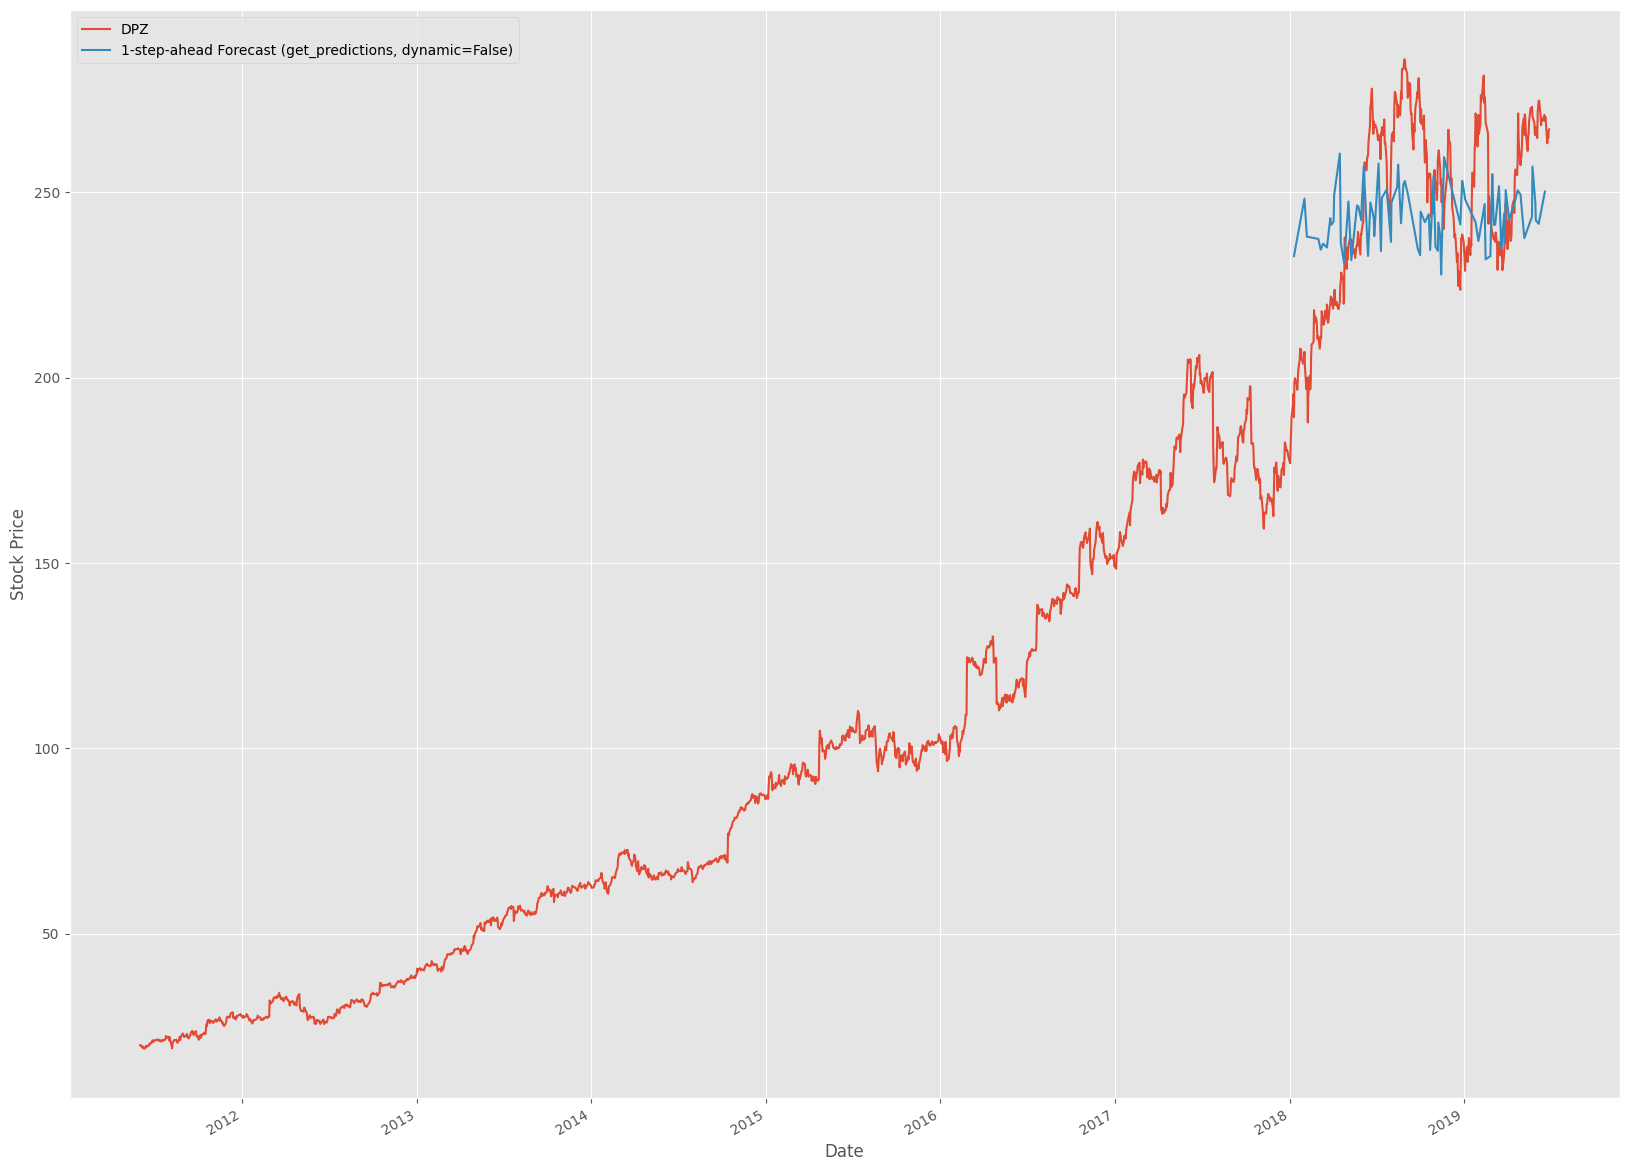

In [209]:
ax = data['DPZ'][:test_interval_dates[-1]].plot(figsize=(20, 16))
pred0_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend()
plt.show()

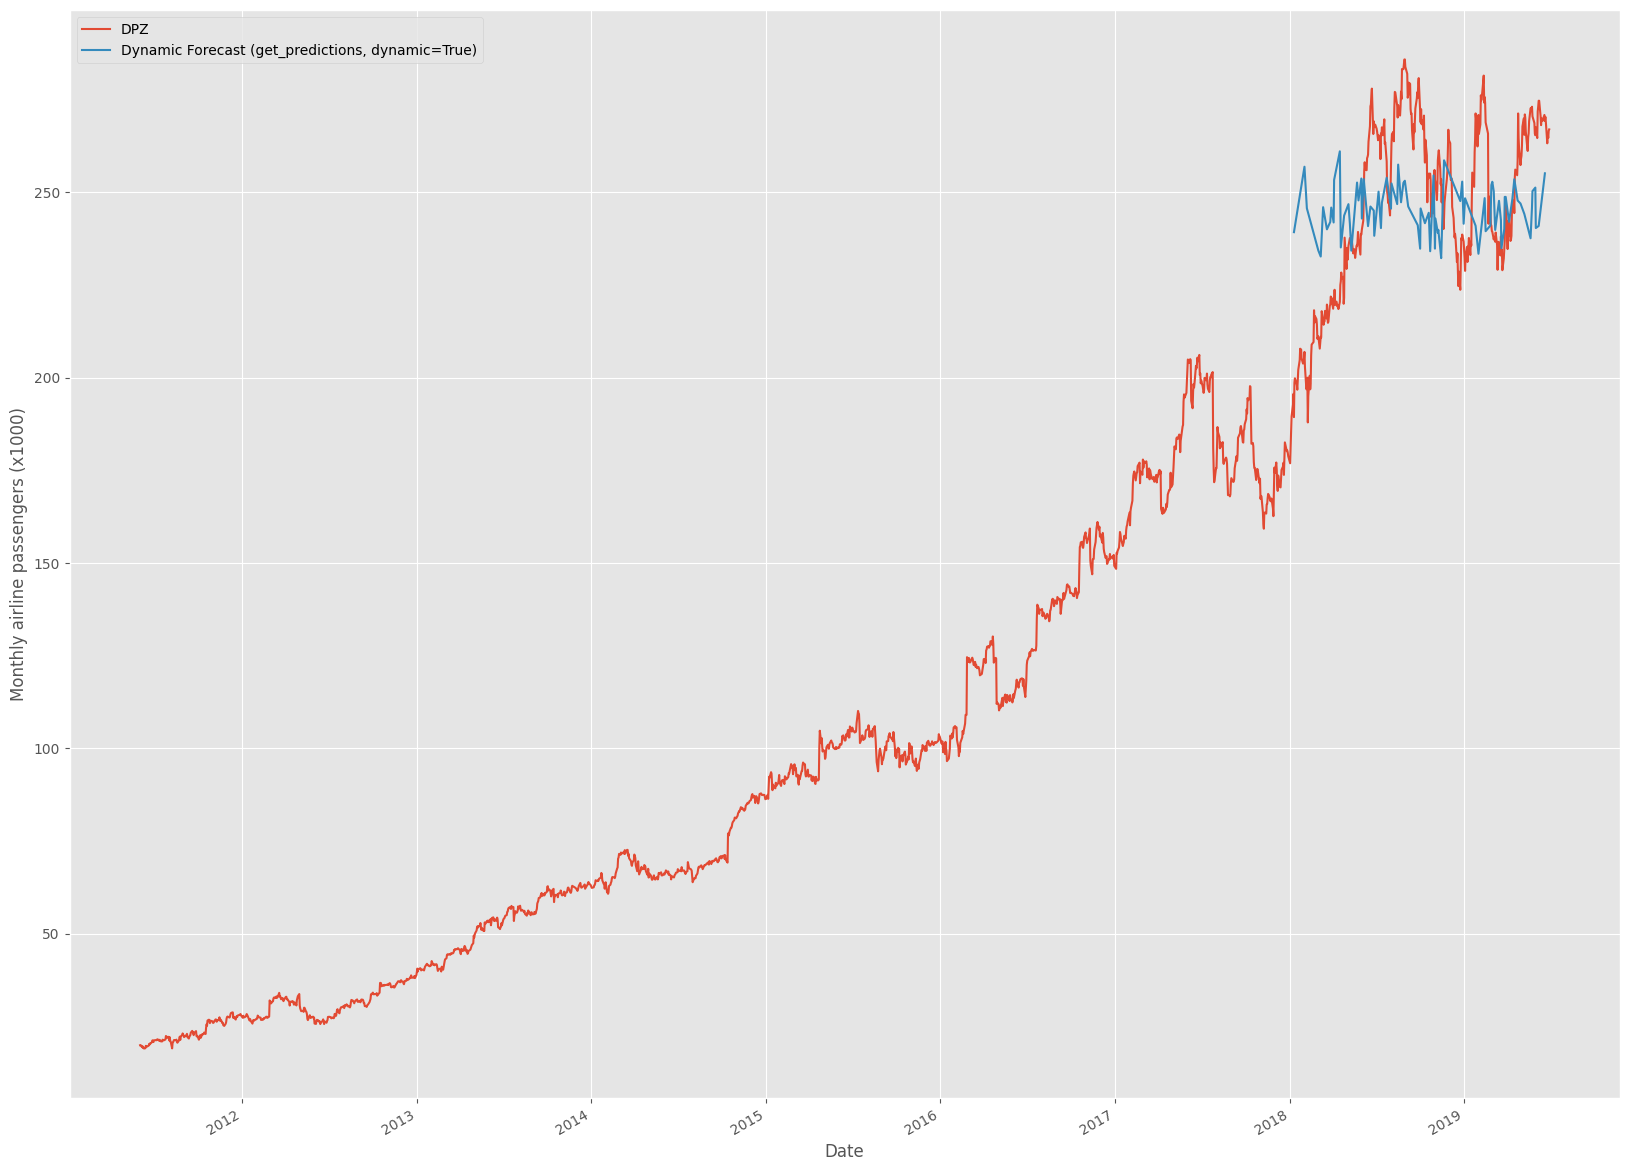

In [210]:
ax = data['DPZ'][:test_interval_dates[-1]].plot(figsize=(20, 16))
pred1_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend()
plt.show()